# ProdLDA

In [1]:
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ProdLDA import ProdLDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real
import torch
import numpy as np
import pandas as pd
import string
import os
from wordcloud import WordCloud
from skopt.space.space import Integer, Real
import time
import matplotlib.pyplot as plt
import json
import spacy
from tqdm import tqdm


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [7]:
from preprocessing.clean_text import *

## Data Setup and preprocessing

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
extract_corpus_and_labels_from_directory(base_path = 'data/bbc/', output_path = 'data/input')

Corpus has been saved to data/input/corpus.txt
Labels have been saved to data/input/labels.txt


In [10]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation = True,
                             punctuation = string.punctuation,
                             remove_numbers = True,
                             lemmatize = True,
                             stopword_list = CUSTOM_STOPWORDS,
                             min_chars = 3,
                             min_words_docs = 10,
                             language = 'english',
                             split = True,
                             verbose = True)

In [11]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists('data/processed/dataset'):
    dataset = preprocessor.preprocess_dataset(documents_path = 'data/input/corpus.txt',labels_path = 'data/input/labels.txt')
    dataset.save('data/processed/dataset')
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder('data/processed/dataset')

In [12]:
dataset.get_metadata()

{'total_documents': 2225,
 'vocabulary_length': 4168,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 10 and higher than 0.85',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 1557,
 'last-validation-doc': 1891}

## Metrics

In [13]:
num_iters = 15
number_of_calls = 60 # Bottleneck for computation time

In [14]:
dataset.get_info()

In [15]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_v') # Initialize metric

## Prod LDA model without optimization

In [16]:
N_TOPICS = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#current_device = torch.cuda.current_device()
#print(f"Currently using GPU: {current_device}")
#print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

Device: cuda


In [17]:
model = ProdLDA(num_topics = N_TOPICS, 
               activation = 'softplus', 
               dropout = 0.2,
               learn_priors = True, 
               batch_size = 64, 
               lr = 2e-3, 
               momentum = 0.99,
               solver = 'adam', 
               num_epochs = 100, 
               reduce_on_plateau = False, 
               prior_mean = 0.0,
               prior_variance = None, 
               num_layers = 2, 
               num_neurons = 64, 
               num_samples = 10,
               use_partitions = True)

In [18]:
coherence_list_no_opt, topic_diversity_list_no_opt = [], []

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset, hyperparameters=None, top_words=10)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1405.787913455363	Time: 0:00:00.712446
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.96338183009	Time: 0:00:00.029608
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1386.2035113599873	Time: 0:00:00.183567
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1347.298190727919	Time: 0:00:00.020346
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1366.2058621347142	Time: 0:00:00.179609
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1340.1016794535929	Time: 0:00:00.023144
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1348.738956125562	Time: 0:00:00.193179
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1340.4551366017963	Time: 0:00:00.023263
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1337.6108978604689	Time: 0:00:00.177315
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1333.4267285741018	Time: 0:00:00.017603
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1331.5639751926783	Time: 0:00:00.155198


  7%|▋         | 1/15 [00:14<03:16, 14.06s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1406.3598127910243	Time: 0:00:00.485664
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.5846977919161	Time: 0:00:00.046411
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1391.6486996728484	Time: 0:00:00.293918
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1347.5477287612275	Time: 0:00:00.039378
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1371.2472064165863	Time: 0:00:00.264250
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1340.7229603293413	Time: 0:00:00.029481
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1354.8125928267502	Time: 0:00:00.162303
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1341.4360146893712	Time: 0:00:00.021436
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1343.9087237074502	Time: 0:00:00.165420
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1333.358170377994	Time: 0:00:00.015596
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1335.6263484967085	Time: 0:00:00.154

 13%|█▎        | 2/15 [00:26<02:47, 12.87s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1406.9231570126847	Time: 0:00:00.759419
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.2229778723802	Time: 0:00:00.038700
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1390.269413334939	Time: 0:00:00.308926
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1344.468831867515	Time: 0:00:00.033684
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1367.7683897318561	Time: 0:00:00.291746
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1336.3274378976423	Time: 0:00:00.039948
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1354.3010634934972	Time: 0:00:00.163219
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1337.9609375	Time: 0:00:00.024838
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1343.248886078998	Time: 0:00:00.152260
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1334.0102919161677	Time: 0:00:00.017060
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1334.1310086504495	Time: 0:00:00.144644
Epoc

 20%|██        | 3/15 [00:39<02:37, 13.10s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1409.8232980089917	Time: 0:00:00.692873
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.730176366018	Time: 0:00:00.048161
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1396.6883153701028	Time: 0:00:00.317347
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1349.887712855539	Time: 0:00:00.042372
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1375.4545751043674	Time: 0:00:00.247759
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1349.7667594498503	Time: 0:00:00.016830
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1359.6704060793995	Time: 0:00:00.131395
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1344.6031179827844	Time: 0:00:00.017714
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1347.5153189226075	Time: 0:00:00.144242
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1339.2945651665418	Time: 0:00:00.017349
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1336.9736535103564	Time: 0:00:00.1544

 27%|██▋       | 4/15 [00:50<02:15, 12.30s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1407.70280136079	Time: 0:00:00.724449
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.4211615830839	Time: 0:00:00.036616
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1398.0029804913295	Time: 0:00:00.341652
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1348.3921453967066	Time: 0:00:00.039929
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1382.8362561215479	Time: 0:00:00.327844
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1349.8912740924402	Time: 0:00:00.023062
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1366.6163771475594	Time: 0:00:00.125193
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1348.7745017776947	Time: 0:00:00.015266
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1356.9687349470134	Time: 0:00:00.133499
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1340.0280805576347	Time: 0:00:00.018026
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1345.0427943862396	Time: 0:00:00.1245

 33%|███▎      | 5/15 [00:58<01:46, 10.67s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1407.5331968529222	Time: 0:00:00.690061
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.4922459767963	Time: 0:00:00.047191
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1392.5368835802024	Time: 0:00:00.314368
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1346.329768197979	Time: 0:00:00.035241
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1373.4857736733302	Time: 0:00:00.248975
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1343.7099901758982	Time: 0:00:00.015762
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1357.159911638969	Time: 0:00:00.124713
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1347.1208715381736	Time: 0:00:00.019035
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1344.2520835842165	Time: 0:00:00.145993
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1329.8165173559132	Time: 0:00:00.014937
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1333.6359171784682	Time: 0:00:00.1289

 40%|████      | 6/15 [01:07<01:30, 10.08s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1406.6840064527134	Time: 0:00:00.822168
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.752473568488	Time: 0:00:00.041856
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1394.4912542148363	Time: 0:00:00.302913
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1348.448177863024	Time: 0:00:00.032097
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1376.6645140895953	Time: 0:00:00.300664
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1348.116438997006	Time: 0:00:00.025033
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1359.3270863439307	Time: 0:00:00.138697
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1340.6718340662426	Time: 0:00:00.015392
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1344.375513055957	Time: 0:00:00.196454
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1339.9479790419161	Time: 0:00:00.017409
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1334.6765878391939	Time: 0:00:00.145562

 47%|████▋     | 7/15 [01:16<01:18,  9.75s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1405.3594176501285	Time: 0:00:00.738430
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.93278092253	Time: 0:00:00.038884
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1386.9410725754656	Time: 0:00:00.297511
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1346.3381479229042	Time: 0:00:00.041825
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1366.0412426742132	Time: 0:00:00.321171
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1338.9124368450598	Time: 0:00:00.016115
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1350.8988276232337	Time: 0:00:00.131287
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1332.6164331493264	Time: 0:00:00.019824
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1336.0872772157995	Time: 0:00:00.161649
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1328.1765180576347	Time: 0:00:00.014962
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1329.2960420680797	Time: 0:00:00.1242

 53%|█████▎    | 8/15 [01:27<01:10, 10.09s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1406.5895150931278	Time: 0:00:00.619033
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.6666120883233	Time: 0:00:00.037248
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1389.5069933666507	Time: 0:00:00.302672
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1348.8572405969312	Time: 0:00:00.036608
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1371.292187249117	Time: 0:00:00.289694
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1345.2688587668413	Time: 0:00:00.016882
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1352.7762636982177	Time: 0:00:00.136457
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1341.46923535741	Time: 0:00:00.020299
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1342.8743577392422	Time: 0:00:00.138116
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1334.1439230913174	Time: 0:00:00.021231
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1335.2101233843127	Time: 0:00:00.14636

 60%|██████    | 9/15 [01:35<00:57,  9.57s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1409.305776332691	Time: 0:00:00.596404
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.7643852919161	Time: 0:00:00.034635
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1392.2217003853564	Time: 0:00:00.308503
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1346.2581633607786	Time: 0:00:00.036262
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1372.30925231816	Time: 0:00:00.255026
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1340.5578160086077	Time: 0:00:00.017044
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1358.0307281631342	Time: 0:00:00.183034
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1345.7470469217815	Time: 0:00:00.021917
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1345.1508911368016	Time: 0:00:00.141325
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1347.1835528162426	Time: 0:00:00.024748
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1335.628404483783	Time: 0:00:00.149352

 67%|██████▋   | 10/15 [01:46<00:49,  9.89s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1407.3763171363198	Time: 0:00:00.726248
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1350.0526934412426	Time: 0:00:00.043819
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1390.773056157675	Time: 0:00:00.312797
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1349.8190377058384	Time: 0:00:00.031750
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1374.5686240566795	Time: 0:00:00.283902
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1346.790120930015	Time: 0:00:00.015202
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1358.6909220456005	Time: 0:00:00.140277
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1343.2874953218563	Time: 0:00:00.014852
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1348.0395567397238	Time: 0:00:00.158142
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1338.0217182821857	Time: 0:00:00.015229
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1337.484492915061	Time: 0:00:00.17795

 73%|███████▎  | 11/15 [01:54<00:37,  9.47s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1405.7081953476236	Time: 0:00:00.748983
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1350.1537238023952	Time: 0:00:00.043429
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1387.5410344412333	Time: 0:00:00.316079
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1347.4788664857786	Time: 0:00:00.040267
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1365.3213611913936	Time: 0:00:00.301920
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1341.0709089633233	Time: 0:00:00.037622
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1348.7685967104208	Time: 0:00:00.162162
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1337.4252081773952	Time: 0:00:00.025377
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1337.4467952191715	Time: 0:00:00.155885
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1331.4925032747005	Time: 0:00:00.019506
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1332.891787843208	Time: 0:00:00.162

 80%|████████  | 12/15 [02:03<00:27,  9.26s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1407.9999021555877	Time: 0:00:00.773230
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.837206446482	Time: 0:00:00.038463
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1391.797492172447	Time: 0:00:00.322918
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1348.1118368731288	Time: 0:00:00.035585
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1373.8173784220455	Time: 0:00:00.290300
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1346.7043647080839	Time: 0:00:00.030694
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1357.6775575024085	Time: 0:00:00.154191
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1346.7148788360778	Time: 0:00:00.015294
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1346.9487596339113	Time: 0:00:00.152663
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1343.140706867515	Time: 0:00:00.014752
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1338.6735559168271	Time: 0:00:00.15185

 87%|████████▋ | 13/15 [02:13<00:18,  9.40s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1405.9481248996467	Time: 0:00:00.611198
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.8183359842815	Time: 0:00:00.041439
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1386.7462455342807	Time: 0:00:00.328337
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1346.0152390531437	Time: 0:00:00.038572
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1367.6146723968368	Time: 0:00:00.271142
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1337.2596486714071	Time: 0:00:00.036709
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1352.0696451509314	Time: 0:00:00.152090
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1336.8908238211077	Time: 0:00:00.020222
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1341.9105175216764	Time: 0:00:00.156597
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1335.8002491111527	Time: 0:00:00.015357
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1331.4718258269106	Time: 0:00:00.16

 93%|█████████▎| 14/15 [02:24<00:10, 10.05s/it]

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1410.29242558807	Time: 0:00:00.641994
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1349.7258081493264	Time: 0:00:00.045173
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1398.7053064286288	Time: 0:00:00.315843
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1349.7460060348053	Time: 0:00:00.043725
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1380.4891166907514	Time: 0:00:00.259969
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1347.9052617421407	Time: 0:00:00.023526
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1362.3145497149967	Time: 0:00:00.164072
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1348.6212282466317	Time: 0:00:00.016358
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1351.2684624879575	Time: 0:00:00.161378
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1346.0117772267963	Time: 0:00:00.014263
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1337.8004726637764	Time: 0:00:00.1598

100%|██████████| 15/15 [02:33<00:00, 10.24s/it]

Mean coherence:  0.6496531019219576 
Mean topic diversity:  0.9906666666666666


## Prod LDA model with optimization

In [19]:
model = ProdLDA()

In [20]:
# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=25),
                "lr": Real(low=1e-4, high=0.01),
                "momentum": Real(low=0.99, high= 0.9999),
                "num_neurons": Integer(low=32, high=256),} 

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

In [21]:
start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path = "results/test_ProdLDA", # path to store the results
                            number_of_call = number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs = num_iters, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen = True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123,
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')
results = json.load(open("results/test_ProdLDA/result.json",'r'))

Current call:  0
Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1403.9035279182724	Time: 0:00:00.780613
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1360.7422284337574	Time: 0:00:00.053213
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1355.734430194284	Time: 0:00:00.633121
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1331.1047670284431	Time: 0:00:00.045956
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1329.2848476637764	Time: 0:00:00.394227
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1314.5340861246257	Time: 0:00:00.042485
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1315.191759995183	Time: 0:00:00.304115
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1306.8523548605913	Time: 0:00:00.024118
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1305.1077091361592	Time: 0:00:00.163015
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1303.3504748315868	Time: 0:00:00.018993
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1299.7299945809248	T

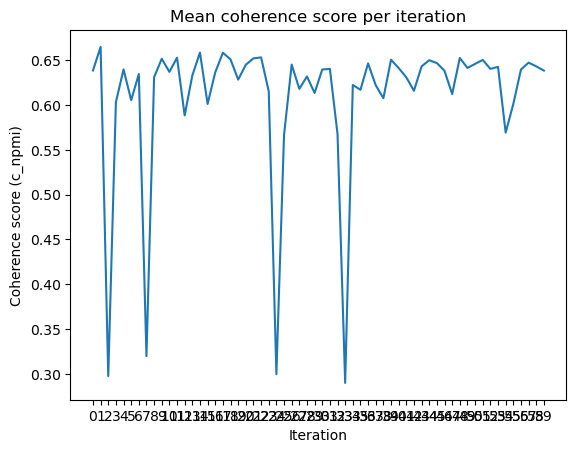

In [22]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Mean coherence score per iteration')

coherences = results['dict_model_runs']['Coherence']

mean_coherences = [np.mean(coherences[key]) for key in coherences.keys()]

plt.plot(mean_coherences)
plt.xticks(range(len(mean_coherences)))
plt.show()


In [23]:
print(np.max(mean_coherences))

max_index = np.argmax(mean_coherences)

0.6648325882961778


In [27]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
lr = results["x_iters"]["lr"][max_index]
momentum = results["x_iters"]["momentum"][max_index]
num_neurons = results["x_iters"]["num_neurons"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal learning rate: ", lr)
print("Optimal momentum: ", momentum)
print("Optimal number of neurons: ", num_neurons)

dict_keys(['lr', 'momentum', 'num_neurons', 'num_topics'])
Optimal number of topics:  7
Optimal learning rate:  0.0030404428952763947
Optimal momentum:  0.9940709165578047
Optimal number of neurons:  249


In [28]:
model = ProdLDA(num_topics = num_topics, 
               activation = 'softplus', 
               dropout = 0.2,
               learn_priors = True, 
               batch_size = 64, 
               lr = lr,
               momentum = momentum,
               solver = 'adam', 
               num_epochs = 100, 
               reduce_on_plateau = False, 
               prior_mean = 0.0,
               prior_variance = None, 
               num_layers = 2, 
               num_neurons = num_neurons, 
               num_samples = 10,
               use_partitions = True)

In [29]:
coherence_list, topic_diversity_list, outputs = [], [], []

for i in range(num_iters):
  output = model.train_model(dataset, top_words=10)
  outputs.append(output)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

Epoch: [1/100]	Samples: [1557/155700]	Train Loss: 1403.2401729086384	Time: 0:00:00.822865
Epoch: [1/100]	Samples: [334/33400]	Validation Loss: 1356.3984462715196	Time: 0:00:00.057529
Epoch: [2/100]	Samples: [3114/155700]	Train Loss: 1368.7686707209377	Time: 0:00:00.462810
Epoch: [2/100]	Samples: [334/33400]	Validation Loss: 1337.28027051366	Time: 0:00:00.074122
Epoch: [3/100]	Samples: [4671/155700]	Train Loss: 1340.9944630097946	Time: 0:00:00.419236
Epoch: [3/100]	Samples: [334/33400]	Validation Loss: 1329.220784992515	Time: 0:00:00.017548
Epoch: [4/100]	Samples: [6228/155700]	Train Loss: 1326.4839221559891	Time: 0:00:00.159206
Epoch: [4/100]	Samples: [334/33400]	Validation Loss: 1315.5422787238024	Time: 0:00:00.019290
Epoch: [5/100]	Samples: [7785/155700]	Train Loss: 1314.2962452833976	Time: 0:00:00.185015
Epoch: [5/100]	Samples: [334/33400]	Validation Loss: 1298.8097398952095	Time: 0:00:00.028285
Epoch: [6/100]	Samples: [9342/155700]	Train Loss: 1308.560620885517	Time: 0:00:00.199212

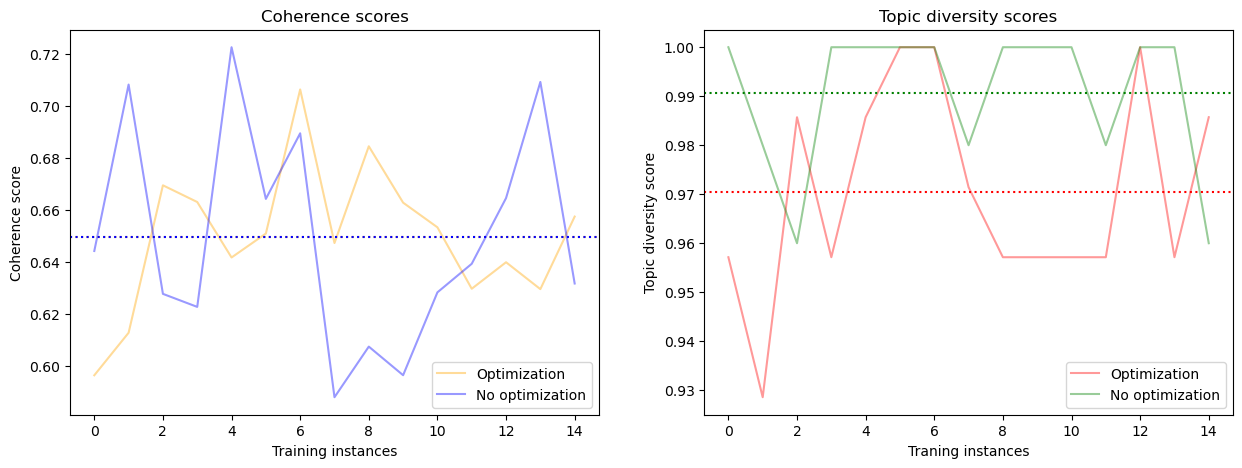

In [30]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt).
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()




In [31]:
# Extract the best output from the outputs list according to a linear combination of the coherence and topic diversity scores

best_output = outputs[np.argmax([0.7*coherence_list[i] + 0.3*topic_diversity_list[i] for i in range(len(coherence_list))])]


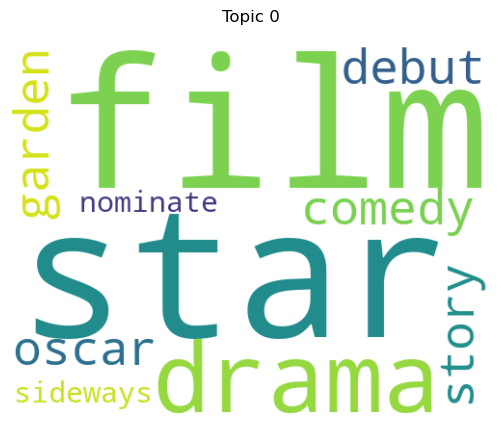

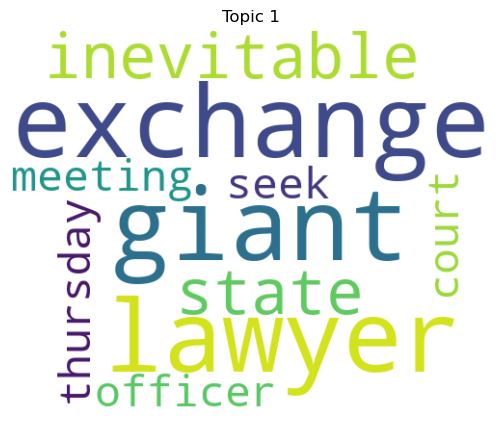

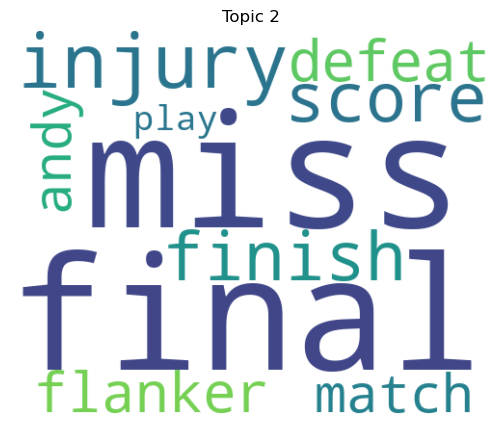

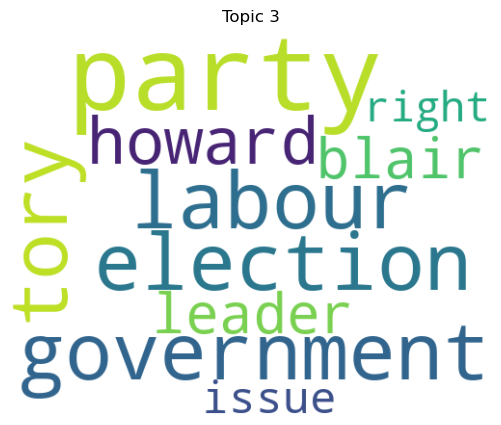

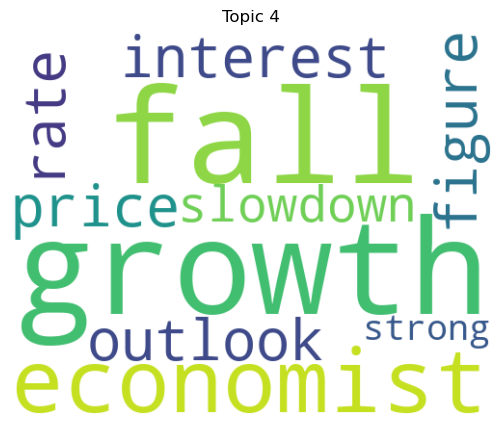

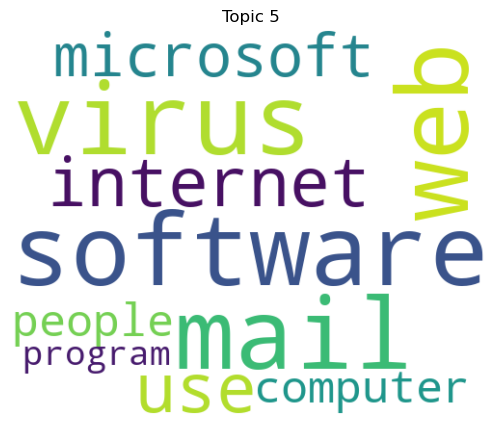

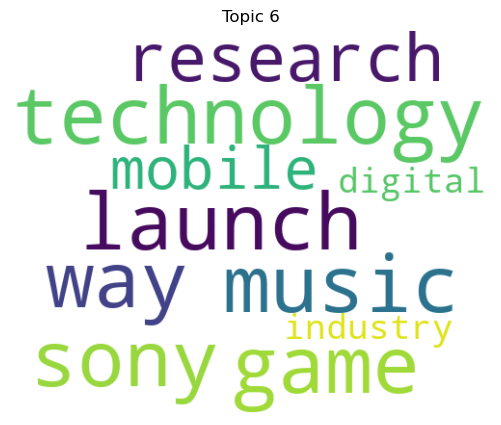

In [32]:
topics = best_output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()

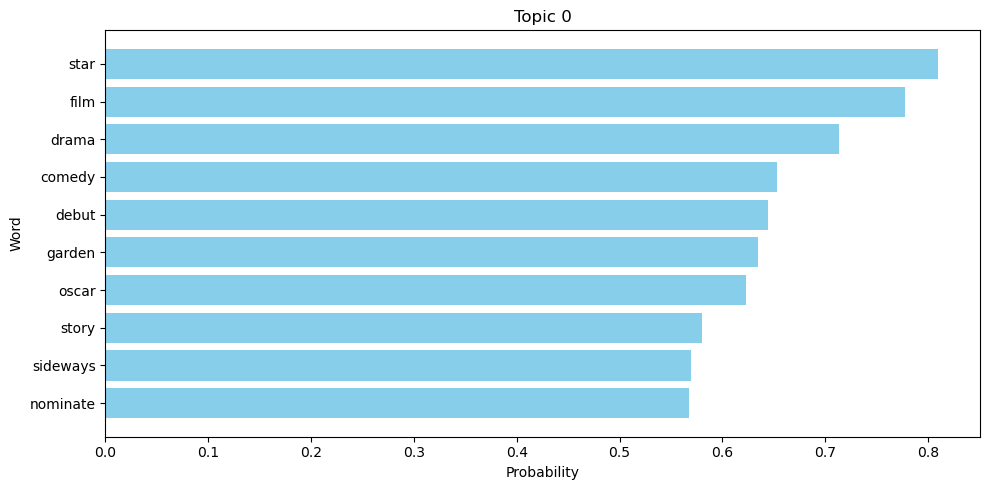

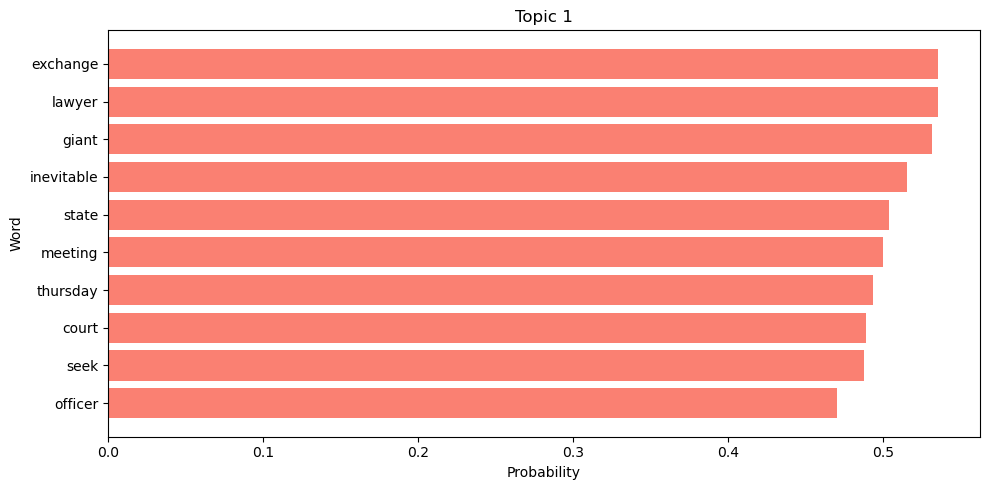

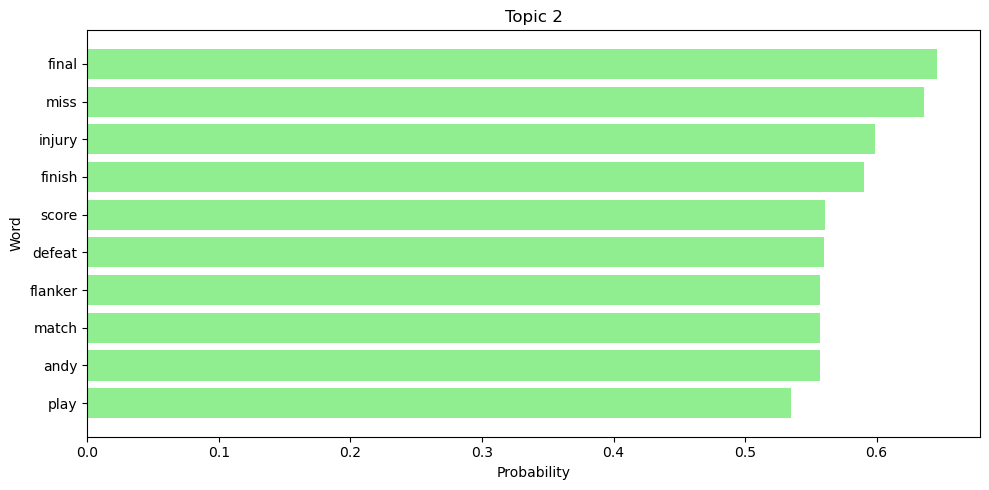

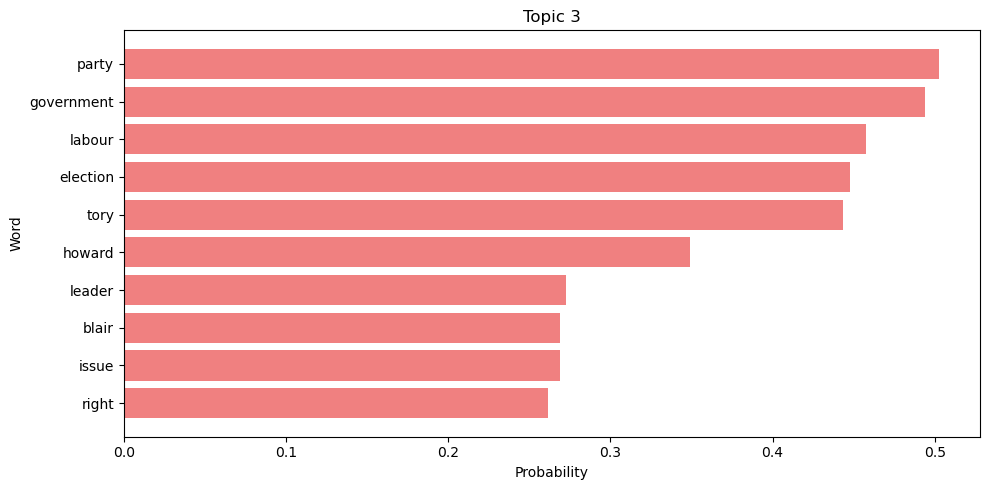

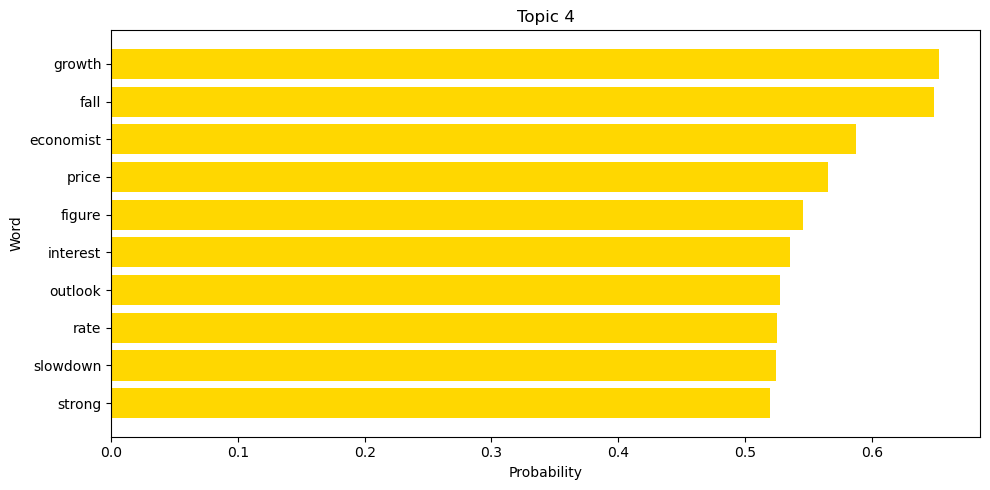

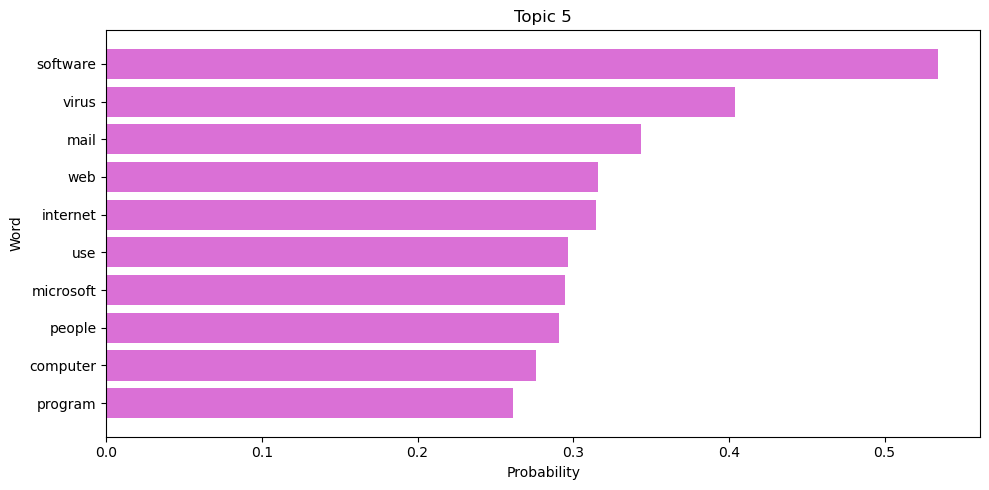

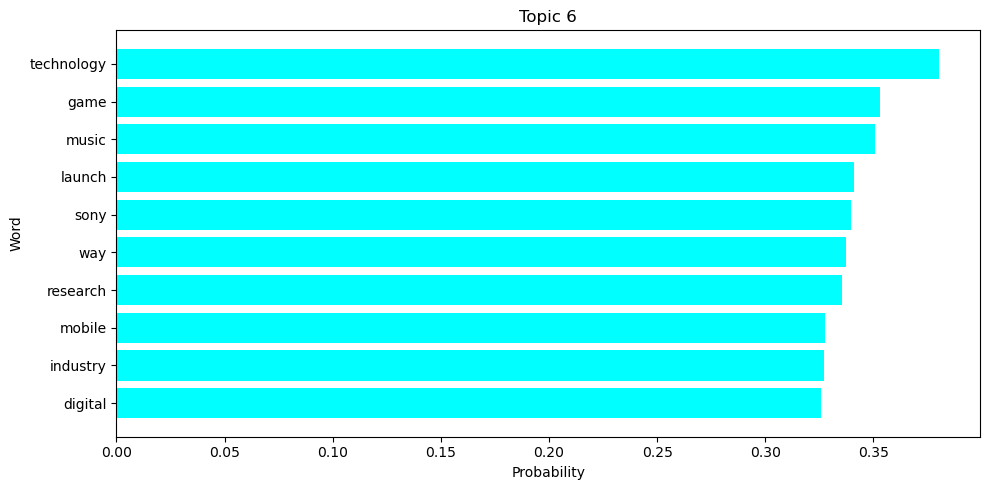

In [33]:
topic_word_matrix = best_output['topic-word-matrix']
words = best_output['topics'] # List of all words in the vocabulary


# Number of words to display 
top_n_words = 10

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = words[i]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()